# Loan Approval (Final Report)

## Overview

A loan approval model is essential for financial institutions to assess borrower risk efficiently and make data-driven lending decisions. It helps minimize defaults, optimize credit allocation, and ensure fair, consistent evaluations. By leveraging machine learning, lenders can improve accuracy and streamline the approval process.

**Key Questions**

1) What loan characteristics (amount, interest rate) are most predictive of defaults so that banks and other financial institutions can optimize its loan portfolio to maximize returns while minimizing risk?
2) How can we detect high-risk or suspicious applications early?

Addressing these questions is crucial, as they directly impact real-world applications, helping financial institutions make informed decisions and improve risk management strategies.

This notebook is the final product of a longer project that focuses on not just building the best machine learning model to predict loan approval, but also to interpret the data in a logical way and conduct analysis and inferences that provide real world value. For more information on why certain decisions were made in this notebook, please check out the [analysis.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/analysis.ipynb) and [experiments.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/experiments.ipynb) where I go into detail on why the data was processed in a certain way or why a certain model was chosen. Otherwise, this notebook is the consolidation of the work that have been conducted in those notebooks.

## Data Analysis

Here are the descriptions of each feature in the dataset:
* `id (int)` - The unique identifier of each loan.
* `person_age (int)` - The age of the loan applicant (the person applying for a loan).
* `person_income (int)` - The annual income of the loan applicant at the time of application.
* `person_home_ownership (str)` - The status of home ownership of the loan application a the time of applicaation.
* `person_emp_length (float)` - The employment length of the loan applicant at the time of application.
* `loan_intent (str)` - The intent of the loan.
* `loan_grade (str)` - The grade of the loan.
* `loan_amnt (int)` - The amount of the loan.
* `loan_int_rate (float)` - The interest rate of the loan - rounded to the nearest 2 decimal points.
* `loan_percent_income (float)` - The percentage of the loan relative to the applicant's income. Calculated as loan_percent_incomet = loan_amnt / person_income. Rounded to the nearest 2 decimal points.
* `cb_person_default_on_file (boolean)` - Whether the applicant has a history of a loan default.
* `cb_person_cred_hist_length (int)` - The credit length history of the applicant (generally the longer the better).
* `loan_status (int)` - Whether the loan was approved or not. This is the target variable.

These descriptions was done by myself after looking at the data. [This](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536984) and [this](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/discussion/538233) are other sets of descriptions I found on the Kaggle competition's discussion page.

In [1]:
import pandas as pd
import numpy as np
import ydata_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pycaret.classification import ClassificationExperiment

from typing import List

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

As previously mentioned, [analysis.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/analysis.ipynb) contains a lot more details on the techniques that would be applied during the data analysis process. Please feel free to refer to that if further explanation on techniques is needed.

Lets first look at the basic EDA on this dataset. The package [ydata-profiling](https://docs.profiling.ydata.ai/latest/) will be used to speed up the process.

Note: If the widget is not loading, check out the EDA [here](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/ydata_profiles/Loan_Approval_Profiling.html).

In [2]:
pp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Lets also display the data here should the widget not load properly.

In [3]:
df_train.shape

(58645, 13)

In [4]:
df_train.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0  
4                         N                           3            0

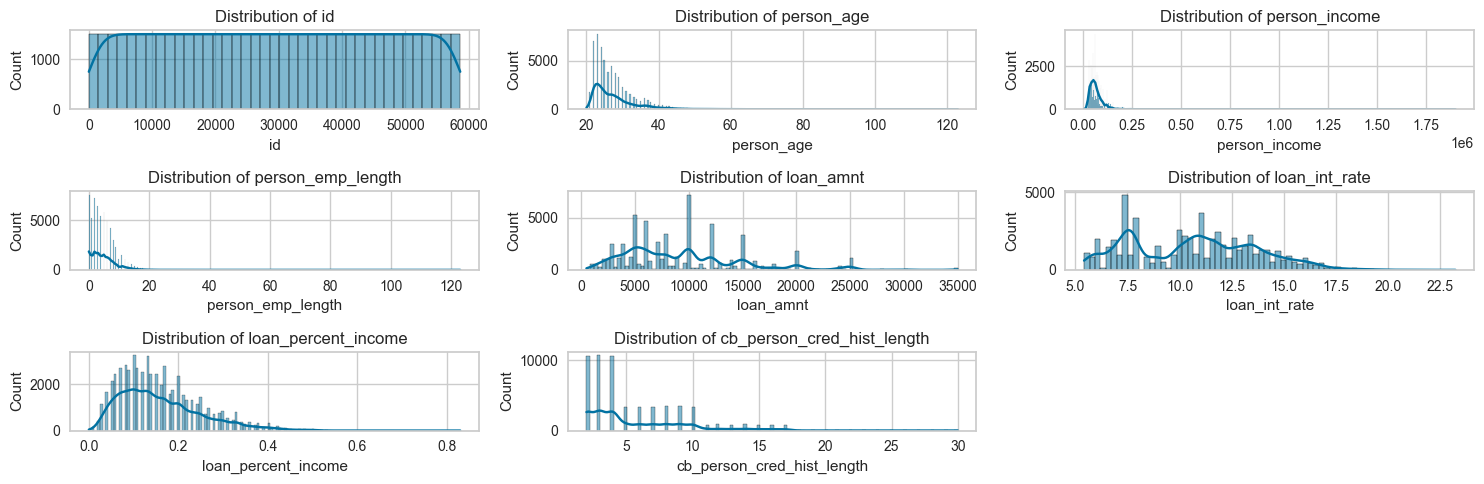

In [5]:
# Initialize numeric features
numeric_features = df_train.select_dtypes(include=['int','float'])

# Create a figure and axes
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(numeric_features.columns[:8]):
    sns.histplot(data=df_train, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

# Remove any empty subplots if there are fewer than 9 features
for j in range(i + 1, 9):
    fig.delaxes(axes[j])

# Display plot
plt.tight_layout()
plt.show()

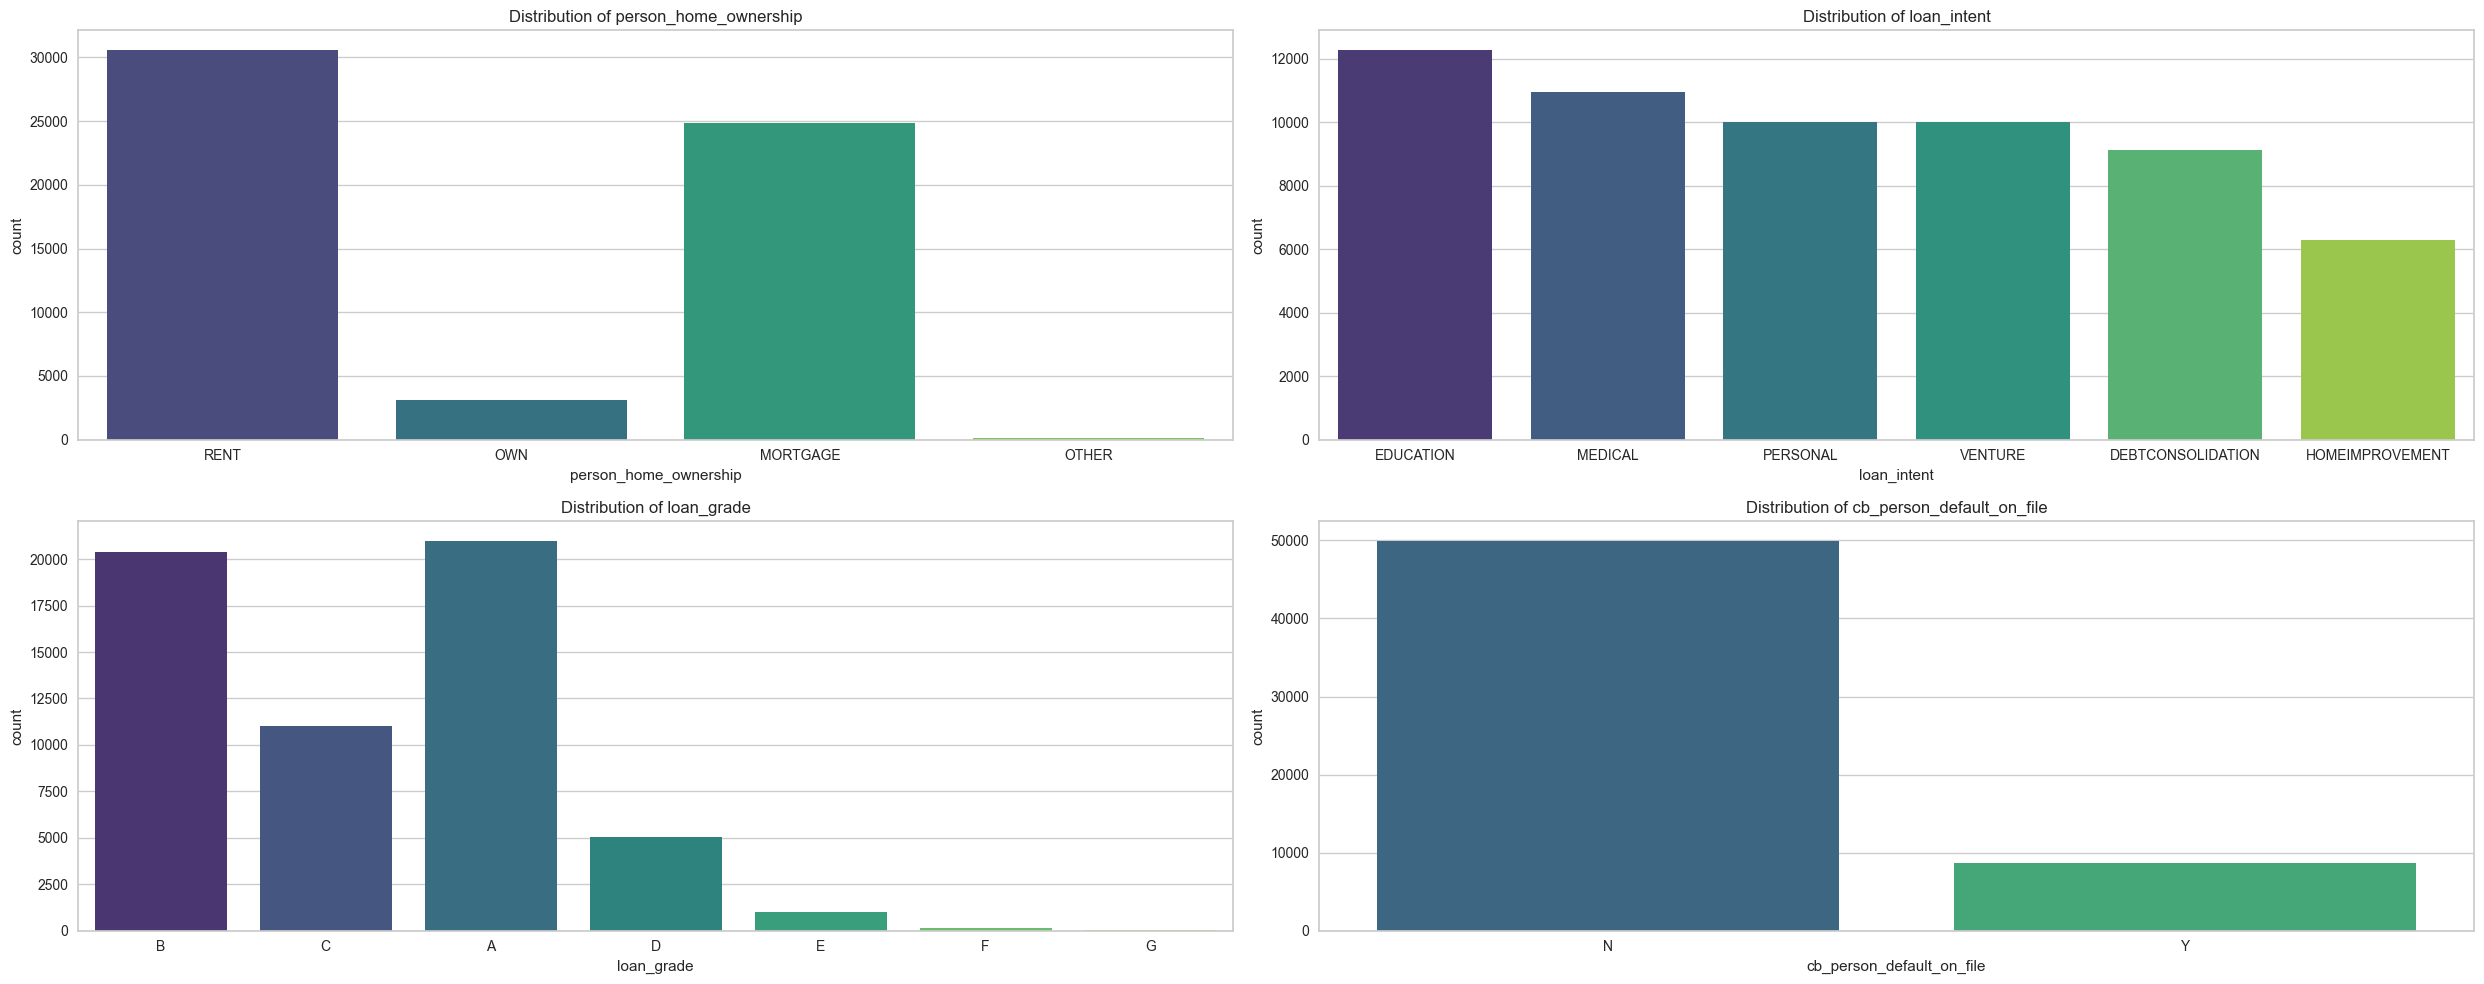

In [6]:
# Initialize categorical features
cat_features = df_train.select_dtypes(include=['object'])

# Create a figure and axes
_, axes = plt.subplots(2, 2, figsize=(25, 10))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(cat_features):
    sns.countplot(data=df_train, x=feature, hue=feature, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

The analysis shows that in our training set, we have almost 60k records of loan applications with each record containing 13 features - including the status of the loan. It can be seen that the distribution of the numerical features is highly positively skewed with most of the data points being closer to 0 with only a handful of applicants having higher values in the features. In terms of categorical features, the intent of the loan seems uniformly distributed while home ownership, grade of the loan, and previous defaults of applicants are all very imbalanced.

While the data doesn't have any missing values according the profile report, analysis has shown that the data contains some inconsistent and even suspicious values that needs to be handled. The data cleaning process will be shown shortly.

Meanwhile, lets dive deeper into the target variable - loan status.

<Axes: xlabel='loan_status', ylabel='count'>

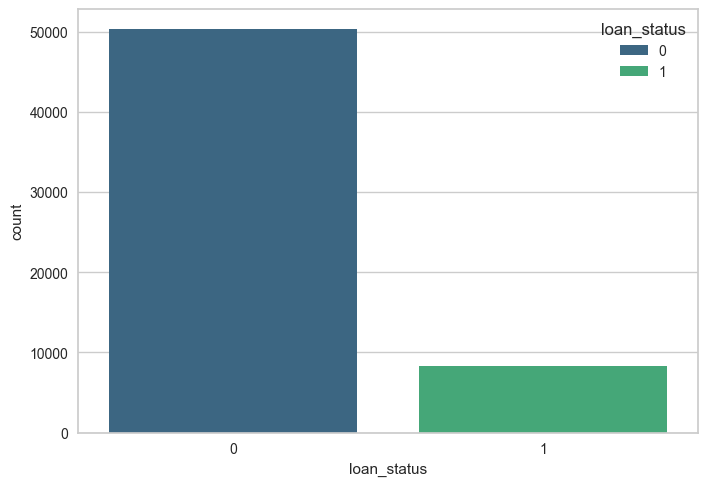

In [7]:
sns.countplot(df_train, x='loan_status', hue='loan_status', palette='viridis')

The graph verifies that only a handful of applicants get their loans approved as expected. More specifically, only 14.2% are approved.

While the low amount matches our expectation of loan approval rates, the imbalance dataset might affect the model negatively. Therefore, oversampling techniques such as SMOTE will be applied prior to model fitting later on.

Lets take a look at the distribution of loan_status across the other features.

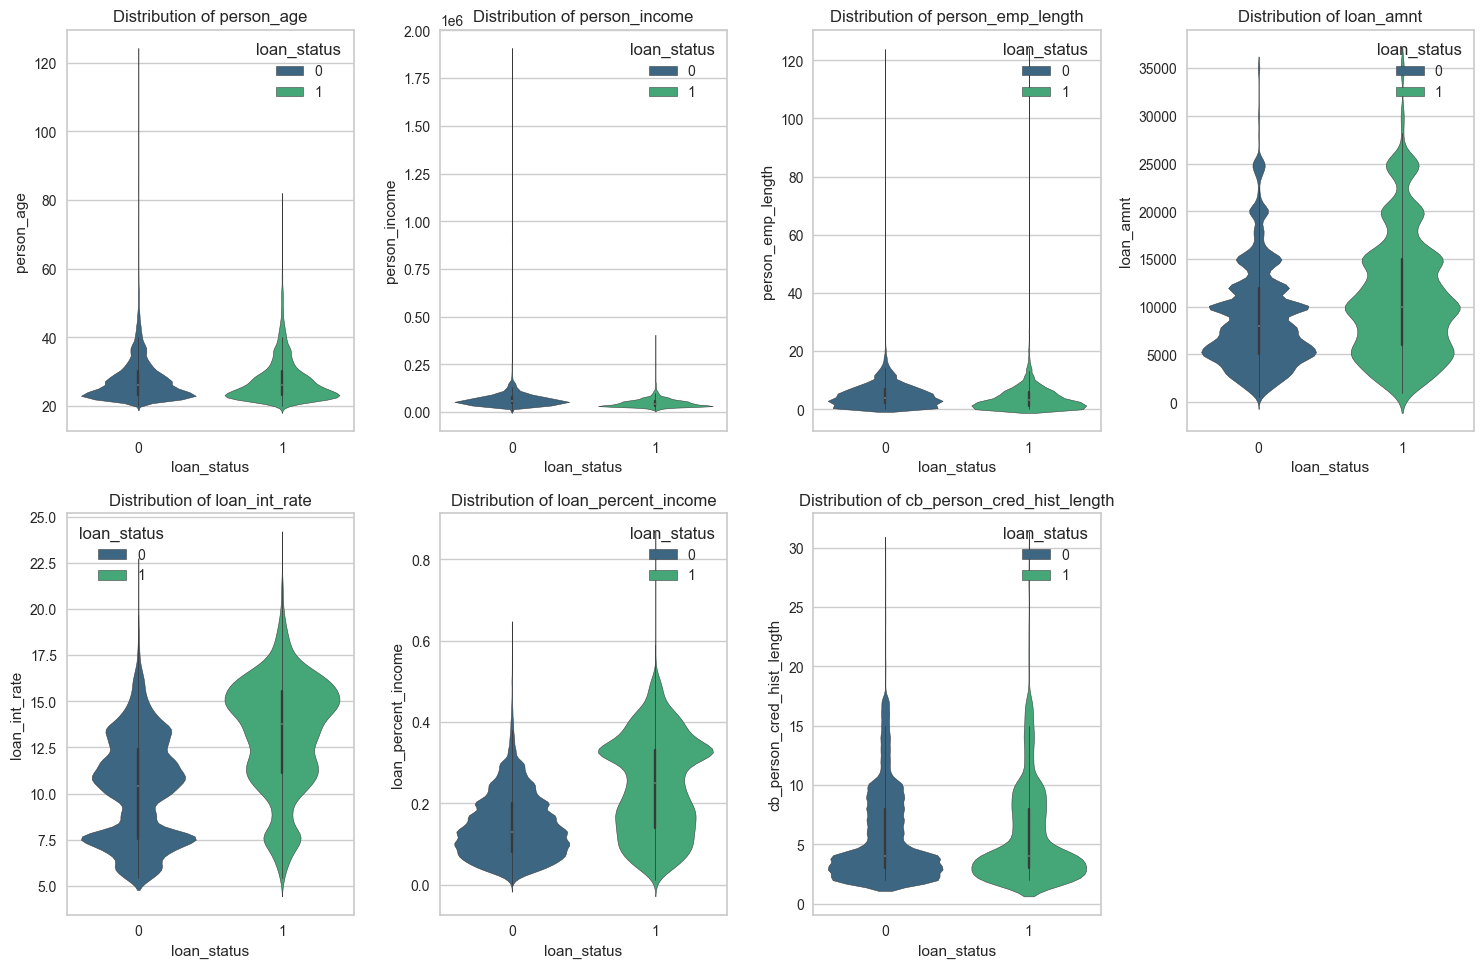

In [8]:
# Violin plots to see distribution of loan status against numerical features
features = [
    "person_age",
    "person_income",
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Create a figure and axes
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(features):
    sns.violinplot(data=df_train, x="loan_status", y=feature, hue="loan_status", palette='viridis', ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

# Remove any empty subplots if there are fewer than 9 features
for j in range(i + 1, 8):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The distribution between those who were approved and those who were denied is quite similar between the two groups aside from loan_amnt, loan_int_rate and loan_percent_income where it can be seen visually that those with an approved loan tend to have higher values on the their income, interest rate and percentage of income. This is important as it gives us an idea on which applicants are more likely to get their loan application approved by the banks. It also sheds light to if potential discrimination that might happen unknowingly as well.

However, it is still too early to tell and a conclusion can only be made once we fit the data to the model and see which features are actually relevant to predict the status of the loan.

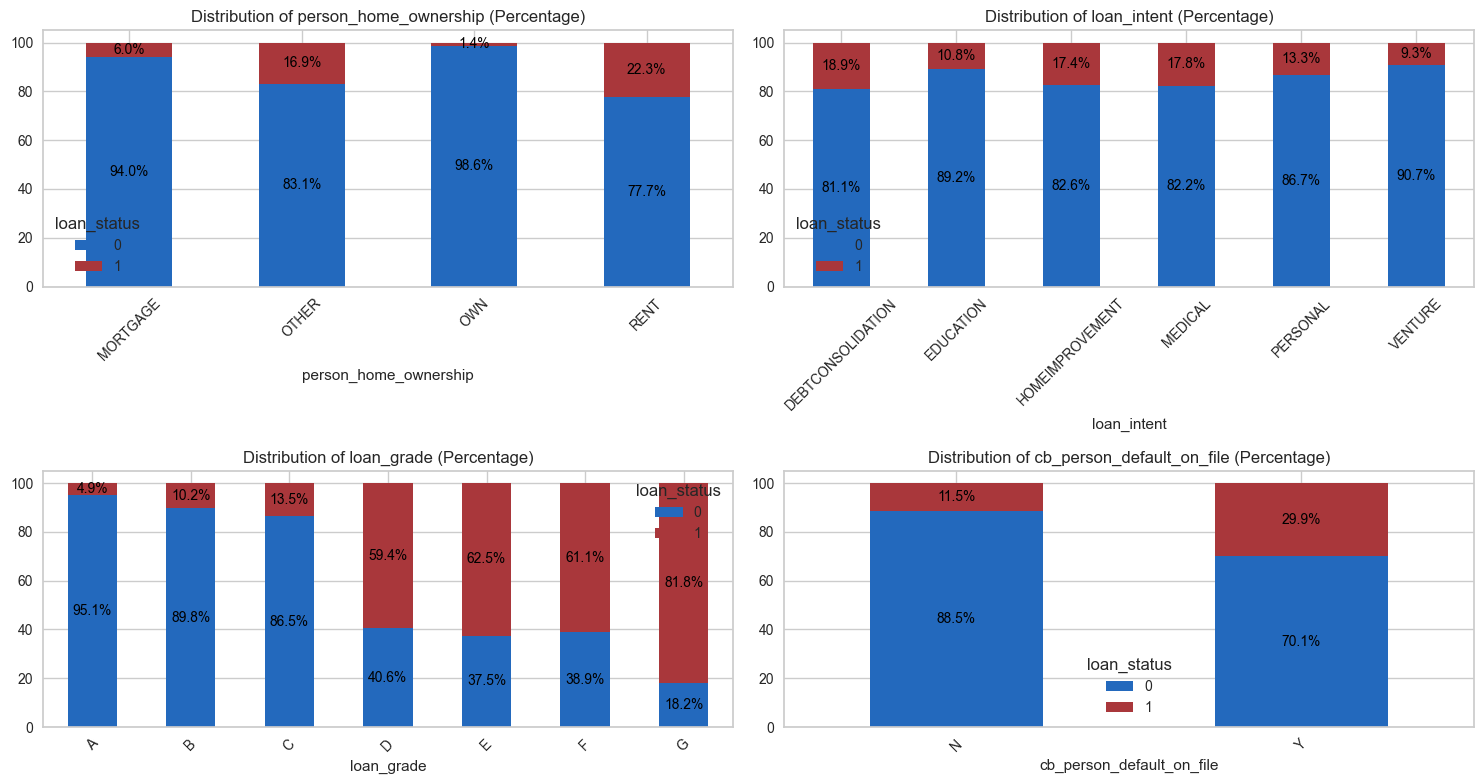

In [9]:
# Percentage Distribution of loan_status across categorical features
features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

# Loop through features and plot
for i, feature in enumerate(features):
    # Compute crosstab and normalize to get percentages
    crosstab = pd.crosstab(df_train[feature], df_train['loan_status'], normalize='index') * 100

    # Create stacked bar plot
    ax = crosstab.plot(kind='bar', stacked=True, colormap='vlag', ax=axes[i])

    # Set title
    axes[i].set_title(f"Distribution of {feature} (Percentage)")

    # Rotate x-axis labels for better visibility
    axes[i].tick_params(axis='x', rotation=45)

    # Annotate each bar with percentage values
    for container in ax.containers:
        # Get the height (i.e., percentage) of each bar segment
        for bar in container:
            height = bar.get_height()
            if height > 0:  # Only annotate non-zero bars
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
                    bar.get_y() + height / 2,  # Y position (middle of bar)
                    f"{height:.1f}%",  # Format percentage with 1 decimal place
                    ha='center', va='center', fontsize=10, color='black'
                )

# Adjust layout
plt.tight_layout()

# Show the final figure
plt.show()

The categorical features provide an even more intersting story as there are clearly certain types of loans and applicants that are more likely to get approved. For example, those who rent a more likely to get their loan approved compared to those who own houses by quite a significant margin. Another example that can be seen is that lower loan grades are actually more likely to get approved compared to higher ones which is surprising. Analysis displayed that lower grades is highly correlated with interest rates where the higher the rate, the lower the grade which makes sense. However, the relationship to getting these loans approved at a higher rate still remains a mystery.

Regardless, now that the data is understood slightly better in relation to the status of the loan, we can proceed with these relationships in mind along with the two key questions. For now, it does seem that certain features impact the status of the loan better than others. Once this is verified by our model, we can use it help predict future loan approvals.

## Data Cleaning
In this section, the data will be cleaned with an additional focus on catching high-risk borrowers and even potential fraudalent information. Once again, only a brief overview of the rationale of the cleaning process will be provided with details remaining in [analysis.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/analysis.ipynb).

During analysis, it was found that there exist a few applicants that violate certain heuristics. These are the violations that were found:
* Applicants who have income but employment history
* Applicants who claimed that they have been working since they were below the legal minimum age of labor.
* Applicants who have their loan_percent_income to be inconsistent.
* Applicants who claimed that they created their credit history before the legal minimum age to obtain credit.

For each of these violations, we will flag the ids of these applicants so that further investigation can be conducted by the proper authorities if need be.

In terms of what this means for our model however, there is a high chance that most of these violations are simply problems during the data entry process either from human error or a system error. Because of that, we will simply clean these occurences by either changing their values or dropping their records if no fixing is available.

In [10]:
def flag_no_emp_high_income(df: pd.DataFrame) -> List[int]:
    return list(df[(df['person_emp_length']==0) & (df['person_income']>0)]['id'])

def flag_min_emp_age_violation(df: pd.DataFrame, min_age_of_employment: int) -> List[int]:
    return list(df[df['person_age'] - df['person_emp_length'] < min_age_of_employment]['id'])

def flag_inconsistent_loan_percentage(df: pd.DataFrame) -> List[int]:
    actual_loan_percent_income = round(df['loan_amnt'] / df['person_income'], 2)
    inconsistent_percentages_df = df.iloc[df['loan_percent_income'].compare(actual_loan_percent_income).index]

    return list(inconsistent_percentages_df['id'])

def flag_credit_history_violation(df: pd.DataFrame, min_age_for_credit: int) -> List[int]:
    df['years_from_min_age'] = df['person_age'] - min_age_for_credit
    credit_history_violaters_df = df[df['years_from_min_age'] < df['cb_person_cred_hist_length']]

    df.drop("years_from_min_age", axis=1, inplace=True)

    return list(credit_history_violaters_df['id'])

In [11]:
no_emp_high_income_ids_train = flag_no_emp_high_income(df_train)
no_emp_high_income_ids_test = flag_no_emp_high_income(df_test)

min_emp_age_violation_ids_train = flag_min_emp_age_violation(df_train, min_age_of_employment=14)
min_emp_age_violation_ids_test = flag_min_emp_age_violation(df_test, min_age_of_employment=14)

inconsistent_loan_percentage_ids_train = flag_inconsistent_loan_percentage(df_train)
inconsistent_loan_percentage_ids_test = flag_inconsistent_loan_percentage(df_test)

credit_history_violation_ids_train = flag_credit_history_violation(df_train, min_age_for_credit=18)
credit_history_violation_ids_test = flag_credit_history_violation(df_test, min_age_for_credit=18)

There is now a record of all potential violations that we have found.

Next, move on to cleaning these records for our model.

In [12]:
def clean_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    """
    Lower the age of any applicants above age_threshold by age_threshold.
    """
    df.loc[df['person_age'] > age_threshold, 'person_age'] -= age_threshold
    return df

def clean_emp_length_by_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    """
    Drop applicants who have their employment length above age_threshold
    """
    violaters = df[df['person_emp_length']>=age_threshold].index
    df.drop(violaters, axis=0, inplace=True)
    return df

def clean_underage_or_impossible_labor(df: pd.DataFrame, min_age_of_employment: int) -> pd.DataFrame:
    """
    Reduce the applicant's employment length such that the earliest age they could have been
    employed is min_age_of_employment which is the minimum age to work at wherever you are.
    """
    # Find the age of when the applicant first started working
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']

    # Find applicants that started working before the min age and take the difference
    diff = 14 - df[df['age_of_first_emp'] < min_age_of_employment]['age_of_first_emp']

    # Subtract diff from person_emp_length
    df.loc[diff.index, 'person_emp_length'] = df.loc[diff.index, 'person_emp_length'] - diff

    # Verify results
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']
    if len(df[df['age_of_first_emp']<min_age_of_employment]) != 0:
        raise ValueError(f"There exist an applicant that started working before they turned {min_age_of_employment}")

    # Drop age_of_first_emp
    df.drop("age_of_first_emp", axis=1, inplace=True)

    return df

def clean_loan_pct_income(df: pd.DataFrame) -> pd.DataFrame:
    """
    Assigns loan_percent_income to be loan_amnt divided by person_income
    """
    df['loan_percent_income'] = round(df['loan_amnt'] / df['person_income'], 2)
    return df

def clean_credit_history(df: pd.DataFrame, min_age_for_credit: int) -> pd.DataFrame:
    """
    Reduce the applicant's credit history length such that the earliest age they could have had
    a credit is min_age_for_credit which is the minimum age to legally acquire a credit at whenever you are.
    """
    # Find age of when the applicant started their credit history
    df['years_from_min_credit_age'] = df['person_age'] - min_age_for_credit

    # Find applicant that started their credit history prior to the min age and take the difference
    diff = df[df['years_from_min_credit_age'] < df['cb_person_cred_hist_length']]

    # Assign years_from_min_credit_age to cb_person_cred_hist_length
    df.loc[diff.index, 'cb_person_cred_hist_length'] = df.loc[diff.index, 'years_from_min_credit_age']

    # Verify results
    if len(df[(df['person_age'] - df['cb_person_cred_hist_length']) < min_age_for_credit]) != 0:
        raise ValueError(f"There exist an applicant that started their credit history before they turned {min_age_for_credit}")

    # Drop years_from_min_credit_age
    df.drop("years_from_min_credit_age", axis=1, inplace=True)

    return df

While there are a lot of functions that were defined to clean the data, we will go over them one by one.

In [13]:
# Reduce applicant age
df_train = clean_age(df_train, age_threshold=100)
df_test = clean_age(df_test, age_threshold=100)

This reduces any applicants who are over 100 years old to be a hundred years younger. This is done because analysis revealed that there were a few people who were over 100 years old which is unlikely. It is suspected that this occurs due to a data entry error is now fixed accordingly.

In [14]:
# Drop applicants who have been working for more than 100 years
df_train = clean_emp_length_by_age(df_train, age_threshold=100)
df_test = clean_emp_length_by_age(df_test, age_threshold=100)

Unlike the previous step, this strictly drops the applicants record from entering the model. While it may be true that it might have been a data entry error, analysis found that there was no way the error would make sense relative to the applicants' ages and it was impossible to recover to suspected true value of their employment history. Furthermore, there were only two records of this violation in the training set and dropping two entries will ultimately not affect our model performance significantly. Further employment history cleaning will also be done in the next step.

In [15]:
# Set applicants employment history so that it matches the legal minimum age of labor
df_train = clean_underage_or_impossible_labor(df_train, min_age_of_employment=14)
df_test = clean_underage_or_impossible_labor(df_test, min_age_of_employment=14)

It is worth noting that I am treating this dataset as data from Canada (even though it actual is a synthetically generated dataset) and the absolute most minimum age someone can legally be employed in Canada is 14. It was found that if we subtracted the number of years the applicant has been working from their age, it goes below 14 years for some applicants. This cleaning process modifies the person_emp_length feature so that this is no longer the case.

Applicants who had their records modified during this process were flagged.

In [16]:
# Fix inconsistent loan_percent_income error
df_train = clean_loan_pct_income(df_train)
df_test = clean_loan_pct_income(df_test)

It was found that some applicants had an inconsistency in their loan_percent_income feature where it was either higher or lower than expected. The expected value for this feature is by dividing the loan_amnt feature by the person_income feature, which is what was used to fix this inconsistency.

There was a suspicion that applicants with this inconsistency might have engaged in fraudulent activities but further analysis revealed that there were no significant differences in loan approval rates between those with this inconsistency and those without.

Applicants who had their records modified during this process were flagged.

In [17]:
# Set applicants credit history so that it matches the legal minimum age to obtain credit
df_train = clean_credit_history(df_train, min_age_for_credit=18)
df_test = clean_credit_history(df_test, min_age_for_credit=18)

Similar to the issue with the applicants' employment histories, some of the applicants' credit histories were also inconsistent with the legal age to obtain credit. Again, the modification was made under the assumption that this dataset is from Canada and that the minimum age to legally obtain credit is 18. The cleaning process modified the cb_person_cred_history_length feature.

Applicants who had their records modified during this process were flagged.

### Data Cleaning Conclusion
This section focused on cleaning out the inconsistencies and even suspicious data from the dataset. Furthermore, there were no missing values in the dataset so that did not need to be handled. Data transformation (to fix skewness), feature engineering, and feature selection will be done in the following sections.

## Feature Engineering
This section will focus on preparing the data to fit the eventual model. Here is what will be done in this section:
* Transform cb_person_default_on_file from str to binary
* Apply ordinal encoding on loan_grade

While this may seem minimal and that certain transformations and processing are missed, those remaining processes will be handled during model building in the next section.

In [18]:
# Transform cb_person_default_on_file from str to binary
df_train['cb_person_default_on_file'] = df_train['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

This process simply turns the feature into numeric representations to fit in the model.

In [19]:
# Apply ordinal encoding on loan_grade
df_train['loan_grade'] = df_train['loan_grade'].map({
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
})

df_test['loan_grade'] = df_test['loan_grade'].map({
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
})

This process transformed the grades of the loan into numerical representations. Since loan grades are have a natural order to them (A is highest/best, G is lowest/worst), ordinal encoding is applied. The other two categorical features in loan_intent and person_home_ownership will be applied with one-hot encoding.

Further feature engineering could be applied but as seen in [experiments.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/experiments.ipynb), this configuration seems to yield the best results as of now.

## Model Building
This section will be focused on building and evaluating models. It will also conduct some data preprocessing and feature engineering in the following ways:
* Normalize numerical features
* Apply one-hot encoding on remaining categorical features
* Apply SMOTE on loan_status to handle target class imbalance

The reason these processes are done in this section and not in the previous sections is because we will be using the [PyCaret](https://pycaret.gitbook.io/docs/get-started/quickstart) library to optimize the model building process.

**Disclaimer**: There are a lot of ways to process the dataset before moving on the model building. For example, other techniques such as ADASYN could have been applied to handle class imbalance or performing PCA on the features for feature selection processes could have also been applied. Some of these options were experimented with in [experiments.ipynb](https://github.com/AnaqiAmir/Loan-Approval-Prediction/blob/main/experiments.ipynb) and are worth looking through. The processes that are applied in this current notebook are what was found to be the best after experimentation.

In [20]:
setup = ClassificationExperiment()
setup.setup(
    df_train.drop('id', axis=1),
    target = 'loan_status',
    normalize=True,
    fix_imbalance=True,
    fix_imbalance_method='SMOTE',
    session_id=123
)
best_model = setup.compare_models()

With the data processing decisions that have been made with a focus on interpretability and performance, it can be seen that the LightGBM model is the best to predict loan approvals. It performed the best in every metric aside from recall where it has a 0.9521 testing accuracy and a 0.9215 testing precision.

Due to its dominance, LightGBM will be used as our final model.

However, it must be also observed that while tree based models performed the best in accuracy metrics, it is interesting to see that non tree models such as logistic regression, SVM, naive bayes, QDA all perform better on recall. In terms of our use case, while precision is incredibly important to reduce false positives (approving loans when they should not have been), recall is just as critical since we do not want to have have false negatives and miss out on potential profitable loan investments.

Therefore, while the final model in this notebook will be LightGBM for prediction, a further exploration into finding models that optimize recall should be utilized as well to get a better picture on the dataset and not miss out on potential high quality loans.

## Model Analysis
This section will focus on analyzing the model's performance. Here are the 3 focus points:
* ROC-AUC curve
* Confusion Matrix
* Feature Importance

**Note**: These evaluations are done on an internal test set that PyCaret created during the model building phase. It does NOT use the df_test dataset.

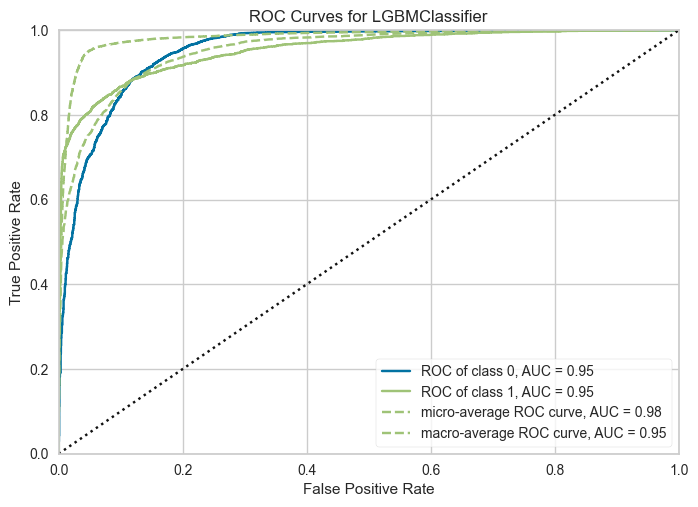

In [21]:
setup.plot_model(best_model, plot = 'auc')

An AUC of 0.95 for both classes indicates that the model is highly effective at predicting loan approvals. The micro-average AUC of 0.98 suggests that the overall model performance is even stronger when considering all instances. However, further testing still needs to be done with other datasets to ensure that the model is not overfitting.

For now, this is a decent result.

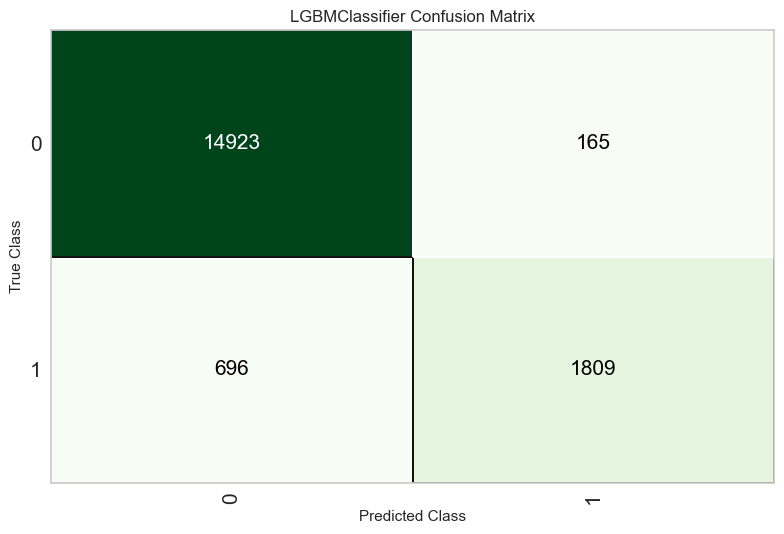

In [22]:
setup.plot_model(best_model, plot = "confusion_matrix")

The confusion matrix shows that we only had 165 cases of false positives and 696 cases of false negatives. This is quite an impressive result as our model is resistant to accidently approving "bad" applicants.

However, further analysis and training might need to be done with more data to improve the false negatives rates as the model is prone to missing out on potential "good" loans to approve - leading to loss in potential opportunities. This is another reason why a separate model that focuses heavy on recall might be worth investigating and creating an ensemble model to handle both cases.

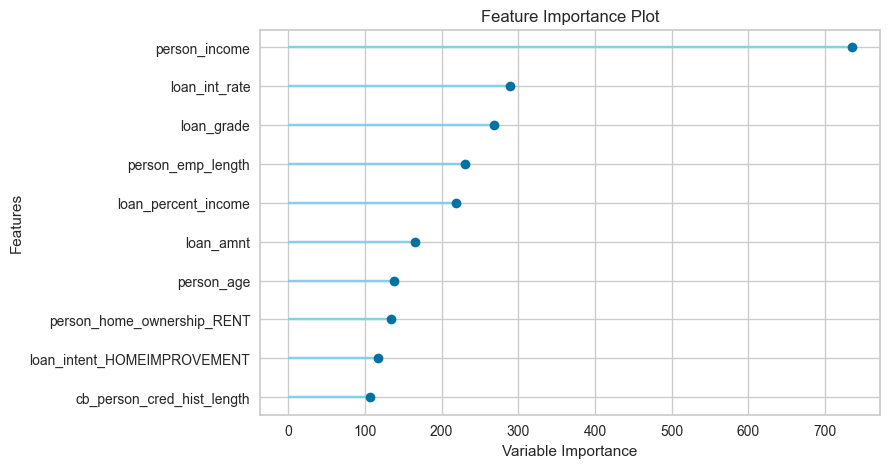

In [23]:
setup.plot_model(best_model, plot = "feature")

Finally, it can be seen clearly which features has the biggest contribution to the model. The applicant's income is by far the most influential while the interest rate and the grade of the loan are second and third in terms of influence. This matches our initial expectation that a person income influences their probability on getting their loan application approved since it would be hard for someone to pay back their loans if they are lacking the income to do so.

While this may seem intuitive, what is important here is that we can now quantify exactly just how much an applicant's income contributes to the their loan approvals.

A surprising insight from this graph is how low loan_percent_income and loan_amnt is on the feature importance list. While the the features above them are understandably where they are, one would expect the amount of loan, or at least the percentage to income, would play a bigger role in determining the approval of an application. This revalation could either mean the model is incomplete, or perhaps it is simply just the case the loan amount does not matter to loan approval rates as much as one would think.

## Prediction on df_test
Predicting on the df_test using the current LightGBM model.

In [24]:
predictions = setup.predict_model(best_model, data=df_test)
predictions.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent  loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT           6      25000      15.760000   
1           PERSONAL           3      10000      12.680000   
2            VENTURE           5       4000      17.190001   
3  DEBTCONSOLIDATION           1       7000       8.900000   
4    HOMEIMPROVEMENT           4      15000      16.320000   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.36                          0                           2   
1                 0.10                          1                           4   
2                 0.13                          1                           2   
3                 0.14                          0                           7   
4                 0.15                          1                           4   

   prediction_label  prediction_score  
0                 1            0.9941  
1                 0            0.9713  
2                 0            0.6751  
3                 0            0.9851  
4                 0            0.9420

It is worth nothing that the prediction_score column contains the probability that the value is of class prediction_label rather than a traditional threshold based prediction that we often see. Here is the official documentation from [PyCaret](https://pycaret.gitbook.io/docs/get-started/quickstart#predictions):

_"Score means the probability of the predicted class (NOT the positive class). If prediction_label is 0 and prediction_score is 0.90, this means 90% probability of class 0. If you want to see the probability of both the classes, simply pass raw_score=True in the predict_model function."_

In [26]:
# Formatting to submit on Kaggle
final_submission = predictions[['id', 'prediction_label']]
final_submission.rename(columns={"prediction_label": "loan_status"})
final_submission.to_csv("data/final_submission.csv", index=False)

## Save flagged ids

In [27]:
from itertools import zip_longest

def create_dataframe_from_unequal_lists(lists, column_names=None, fill_value=None):

    combined_data = list(zip_longest(*lists, fillvalue=fill_value))

    if column_names is None:
        column_names = [f"List{i+1}" for i in range(len(lists))]

    df = pd.DataFrame(combined_data, columns=column_names)
    return df

flags_train = [
    no_emp_high_income_ids_train,
    min_emp_age_violation_ids_train,
    inconsistent_loan_percentage_ids_train,
    credit_history_violation_ids_train
]
flags_test = [
    no_emp_high_income_ids_test,
    min_emp_age_violation_ids_test,
    inconsistent_loan_percentage_ids_test,
    credit_history_violation_ids_test
]
column_names = ['No employment, High income', 'Age Violation', 'Inconsistent Loan Pct', 'Credit History Violation']

flagged_train_ids = create_dataframe_from_unequal_lists(flags_train, column_names=column_names)
flagged_test_ids = create_dataframe_from_unequal_lists(flags_test, column_names=column_names)

flagged_train_ids.to_csv("data/flagged_train_ids.csv", index=False)
flagged_test_ids.to_csv("data/flagged_test_ids.csv", index=False)

## Conclusion

### Model Evaluation and Key Insights
After rigorous experimentation, we have developed a fully functional loan approval model with approximately 95% training accuracy. While its performance on unseen data remains to be validated, the model has been built with interpretability in mind to support real-world business decisions.

### Key Business Questions Revisited:
1) What loan characteristics (e.g., amount, interest rate) are most predictive of approval to help financial institutions optimize their portfolios?
2) How can high-risk or suspicious applications be detected early?

### Findings
* Applicant income is the most significant predictor of loan approval.
* Interest rate and loan grade also contribute but to a lesser extent.
* Loan amount surprisingly has minimal impact, suggesting institutions may need to reassess their approval policies.

### Business Impact
The model streamlines the loan approval process, reducing the need for manual reviews while improving efficiency. However, false positives remain, emphasizing the need for periodic monitoring and model maintenance.

Additionally, during data preprocessing, we identified potential fraudulent activities. To facilitate further investigation, we saved the IDs of suspicious loan applications into a CSV file. While no clear patterns have emerged, deeper analysis could reveal valuable insights.

### Future Improvements
A valuable next step would be integrating this dataset with one that tracks loan defaults. By combining an approval prediction model with a default prediction model, banks can enhance risk assessment and optimize financial strategies, ultimately minimizing losses and maximizing returns.